## Vectorization

In [1]:
import pandas as pd
import numpy as np
import re
import nltk

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

### 1. Load Data

#### Open-ended Answers

In [2]:
quantity_learning = pd.read_csv('./data/quantity_learning.csv')

In [3]:
radio_lessons = pd.read_csv('./data/radio_lessons.csv')

## 2. Count vectorization function
#### 2.1. Retrieve bi/trigrams tokens, refine and encode

In [4]:
stopwords = stopwords.words('english')

In [5]:
def removal(text):
    text = re.sub(r'(\d|\$|\%|\+)', '', text.lower())
    return re.sub(r'\d+', '', text)

In [6]:
def bow_vectorization(data, index, n_grams):
    vectorizer = CountVectorizer(stop_words = stopwords, lowercase = True, strip_accents='unicode', ngram_range=n_grams, preprocessor=removal)
    data_tokens = vectorizer.fit_transform(data)
    print(len(vectorizer.vocabulary_),'words in dictionary.')
    return pd.DataFrame(data_tokens.todense(), columns=vectorizer.get_feature_names(), index=index)

#### 2.2. Search word in vocabulary

In [7]:
def search(word_in=None, word_out=None, vocabulary=None):
    if word_in is None:
        return 'no words to search'

    words = []
    if isinstance(word_in, list):
        for word in word_in:
            for term in vocabulary:
                if word in term:
                    words.append(term)            
    else:
        for term in vocabulary:
            if word_in in term:
                words.append(term)
    
    words_clean = []
    if word_out:
        if isinstance(word_out,str):
            word_out = [word_out]
        for word in word_out:
            for term in words:
                if word in term:
                    pass
                else:
                    words_clean.append(term)
        return words_clean
    else:
        return words

## 3. Questions to vectorize

### 3.4. Are you/your learners learning more or are you learning less using radio lessons since the COVID-19 school closures? Why?

In [8]:
quantity_learning.iloc[:,1].value_counts()

Less        1249
More          80
The same      46
Name: Q52_Are you/your learners learning more or are you learning less using radio lessons since the COVID-19 school closures?, dtype: int64

Get only 'Less' answers

In [9]:
quantity_learning_less = quantity_learning[quantity_learning.iloc[:,1] == 'Less'].iloc[:,2]

In [10]:
quantity_learning[quantity_learning.iloc[:,1] == 'Less'].iloc[:,2].tolist()[:10]

['Because radios are not many in our area',
 'Because of power for charging radio',
 'Because of COVID_19',
 'Due to restrictions by the Covid 19 ',
 'Because of Covid 19 restrictions ',
 'Some teachers in radio lesson use complicated language hard to understand',
 "I don't know",
 'Rodio it is not enough',
 'Teaching is past',
 'Teaching is past in during the lesson']

#### Trigram vectorization
Learning Less with radio lessons after covid

In [11]:
quantity_learning_less_tri = bow_vectorization(data = quantity_learning_less.dropna(), 
                                               index = quantity_learning_less.dropna().index,
                                               n_grams=(3, 3))

1195 words in dictionary.


In [12]:
#quantity_learning_less_tri.sum().sort_values(ascending=False)[:60]

#### Group Trigrams
Trigrams about work

In [13]:
domestic_work = search(['domestic','garden'], None, quantity_learning_less_tri.columns)
len(domestic_work)

57

In [14]:
out_work = search('work', ['domestic','home','house','garden'], quantity_learning_less_tri.columns)
len(out_work)

336

In [15]:
activities = search('activities', 'less', quantity_learning_less_tri.columns)
len(activities)

23

Trigrams about time

In [16]:
time = search('time', None, quantity_learning_less_tri.columns)
len(time)

229

In [17]:
less = search('less', None, quantity_learning_less_tri.columns)
len(less)

189

In [18]:
lack = search('lack', None, quantity_learning_less_tri.columns)
len(lack)

22

Trigrams about education

In [19]:
education = search(['teacher','underst'], None, quantity_learning_less_tri.columns)
len(education)

90

Trigrams about radio

In [20]:
radio = search(['radio','acces','cove'], None, quantity_learning_less_tri.columns)
len(radio)

324

Count one per concept apperance (not word)

In [21]:
domestic_w = quantity_learning_less_tri[domestic_work]

In [22]:
ex_work = quantity_learning_less_tri[list(set(out_work + activities))]

In [23]:
time = quantity_learning_less_tri[list(set(time + less + lack))]

In [24]:
ed = quantity_learning_less_tri[education]

In [25]:
get_radio = quantity_learning_less_tri[radio]

The rest of the Bigrams

In [26]:
other = quantity_learning_less_tri.drop(domestic_w.columns.to_list() + \
                               ex_work.columns.to_list() + \
                               time.columns.to_list() + \
                               ed.columns.to_list() + \
                               get_radio.columns.to_list(), axis=1)
test_other = quantity_learning_less_tri.drop(domestic_w.columns.to_list() + \
                               ex_work.columns.to_list() + \
                               time.columns.to_list() + \
                               ed.columns.to_list() + \
                               get_radio.columns.to_list(), axis=1)

In [27]:
domestic_w = domestic_w.sum(axis=1)
ex_work = ex_work.sum(axis=1)
time = time.sum(axis=1)
ed = ed.sum(axis=1)
other = other.sum(axis=1)

In [28]:
domestic_w[domestic_w != 0] = 1
ex_work[ex_work != 0] = 1
time[time != 0] = 1
ed[ed != 0] = 1
other[other != 0] = 1

In [29]:
domestic = pd.DataFrame(np.zeros(quantity_learning.shape[0]), dtype=int, columns=['domestic work'])
domestic.loc[domestic_w[domestic_w == 1].index,:] = 1
work = pd.DataFrame(np.zeros(quantity_learning.shape[0]), dtype=int, columns=['external work'])
work.loc[ex_work[ex_work == 1].index,:] = 1
no_time = pd.DataFrame(np.zeros(quantity_learning.shape[0]), dtype=int, columns=['no time'])
no_time.loc[time[time == 1].index,:] = 1
no_ed = pd.DataFrame(np.zeros(quantity_learning.shape[0]), dtype=int, columns=['less education'])
no_ed.loc[ed[ed == 1].index,:] = 1
other_w = pd.DataFrame(np.zeros(quantity_learning.shape[0]), dtype=int, columns=['other triagrams'])
other_w.loc[other[other == 1].index,:] = 1

In [30]:
quantity_learning_less_group = pd.concat([domestic, work, no_time, no_ed, other_w], axis=1)

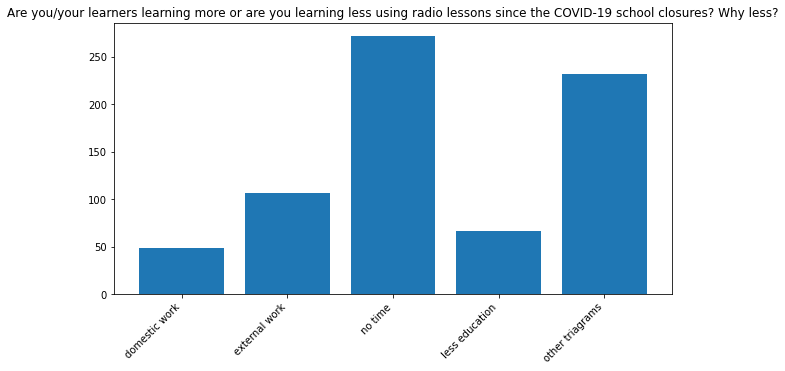

In [31]:
plt.figure(figsize=(10,5))
plt.bar(quantity_learning_less_group.columns, quantity_learning_less_group.sum())
plt.title('Are you/your learners learning more or are you learning less using radio lessons since the COVID-19 school closures? Why less?')
plt.xticks(rotation=45, ha='right')
plt.show()

In [37]:
quantity_learning_less_group.loc[:,'domestic work'].sum() / quantity_learning_less.shape[0]

0.03923138510808647

In [38]:
quantity_learning_less_group.loc[:,'external work'].sum() / quantity_learning_less.shape[0]

0.08566853482786228

In [39]:
quantity_learning_less_group.loc[:,'no time'].sum() / quantity_learning_less.shape[0]

0.2177742193755004

In [40]:
quantity_learning_less_group.loc[:,'less education'].sum() / quantity_learning_less.shape[0]

0.053642914331465175

#### Save vectors and concepts

In [54]:
# tokens
quantity_learning_less_tri.to_csv('data/tokens/quantity_learning_less_yes.csv')
# concepts
quantity_learning_less_group.to_csv('data/concepts/quantity_learning_less_concepts.csv')

### 3.5. What is the quality of the radio lessons? How can the radio lessons be improved?

In [41]:
radio_lessons.notnull().sum()

Unnamed: 0                                        4727
Q57_What is the quality of the radio lessons?     1375
Q58_How can the radio lessons be improved?        1375
dtype: int64

In [42]:
radio_lessons.iloc[:,1].value_counts()

Good         644
Fair         396
Not good     186
Very good    149
Name: Q57_What is the quality of the radio lessons? , dtype: int64

Don't Know

In [43]:
dk_mask = radio_lessons.iloc[:,2].str.contains("don't know", na=False) | \
              radio_lessons.iloc[:,2].str.contains("no know", na=False) | \
              (radio_lessons.iloc[:,2].str.contains("idea", na=False)) | \
              (radio_lessons.iloc[:,2].str.contains("nothing", na=False))

In [44]:
# radio_lessons[dk_mask].iloc[:,2].value_counts()

Group 'Good' with 'Very Good' and 'Not good' with 'Fair'

In [45]:
# fair + not good vs 
radio_lessons_good = radio_lessons[~dk_mask & (radio_lessons.iloc[:,1] == 'Good')].iloc[:,2]

In [46]:
radio_lessons_fair = radio_lessons[~dk_mask & (radio_lessons.iloc[:,1] == 'Fair')].iloc[:,2]

In [47]:
radio_lessons_vgood = radio_lessons[~dk_mask & (radio_lessons.iloc[:,1] == 'Very good')].iloc[:,2]

In [48]:
radio_lessons_ngood = radio_lessons[~dk_mask & (radio_lessons.iloc[:,1] == 'Not good')].iloc[:,2]

#### Trigram Vectorization
Radio Lessons Good Quality

In [49]:
radio_lessons_good_tri = bow_vectorization(data = radio_lessons_good.dropna(),
                                          index = radio_lessons_good.dropna().index,
                                          n_grams=(3, 3))

1138 words in dictionary.


In [50]:
#radio_lessons_good_tri.sum().sort_values(ascending=False)[:30]

#### Group Trigrams
Trigrams about the coverage

In [51]:
coverage_1 = search(['area','cover','extension','tune','network','station','access','rural','fm','power','local'], \
                  'provis', radio_lessons_good_tri.columns)
print(len(coverage_1))

222


In [52]:
coverage_2 = search(['area','cover','extension','tune','network','station','access','rural','fm','power','local'], \
                  'exten', radio_lessons_good_tri.columns)
print(len(coverage_2))

199


In [53]:
coverage_3 = search(['area','cover','extension','tune','network','station','access','rural','fm','power','local'], \
                  'avail', radio_lessons_good_tri.columns)
print(len(coverage_3))

236


In [54]:
coverage_4 = search(['area','cover','extension','tune','network','station','access','rural','fm','power','local'], \
                  'local', radio_lessons_good_tri.columns)
print(len(coverage_4))

204


In [55]:
coverage = list(set(coverage_1 + coverage_2 + coverage_3 + coverage_4))
len(coverage)

199

Trigrams about the provision of radios

In [56]:
power = search(['powe','energ'],None, radio_lessons_good_tri.columns)
len(power)

27

In [57]:
provision = search(['provis','dist','provid','everyone'], None, radio_lessons_good_tri.columns)
len(provision)

160

In [58]:
tv = search(['video', 'tv', 'tele'], None, radio_lessons_good_tri.columns)
len(tv)

12

Trigrams about content

In [59]:
content = search(['subject', 'time', 'guid'], None, radio_lessons_good_tri.columns)
len(content)

224

Trigrams about speech

In [60]:
language = search(['language','trans','arab', 'pronunc'], None, radio_lessons_good_tri.columns)
len(language)

36

In [61]:
speed = search(['speed','unders'], None, radio_lessons_good_tri.columns)
len(speed)

27

Trigrams about teaching

In [62]:
teaching = search(['guide', 'support', 'teacher', 'follow', 'expla', 'slow', 'question'], None, radio_lessons_good_tri.columns)
len(teaching)

172

Tigrams about school re-opening

In [63]:
school = search(['reopen', 'open'], None, radio_lessons_good_tri.columns)
len(school)

19

Tigrams about time (to listen, of broadcast)

In [64]:
time = search(['time', 'repeat', 'timing', 'tmie', 'freq'], None, radio_lessons_good_tri.columns)
len(time)

202

Don't Know (DK)

In [65]:
dk = search(["don't", 'idea', 'nothing'], None, radio_lessons_good_tri.columns)
len(dk)

2

Count one per concept apperance (not word)

In [66]:
cover = radio_lessons_good_tri[coverage]

In [67]:
r_provision = radio_lessons_good_tri[list(set(power + provision + tv))]

In [68]:
l_content = radio_lessons_good_tri[content]

In [69]:
teach = radio_lessons_good_tri[teaching]

In [70]:
r_time = radio_lessons_good_tri[time]

In [71]:
l_speech = radio_lessons_good_tri[list(set(language +  speed))]

The rest of the Trigrams

In [72]:
other = radio_lessons_good_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    teach.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    l_speech.columns.to_list(), axis=1)

In [73]:
test_other = radio_lessons_good_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    teach.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    l_speech.columns.to_list(), axis=1)
len(test_other.columns.to_list())

426

In [74]:
cover = cover.sum(axis=1)
content = l_content.sum(axis=1)
speech = l_speech.sum(axis=1)
time = r_time.sum(axis=1)
provision = r_provision.sum(axis=1)
teach = teach.sum(axis=1)
other = other.sum(axis=1)

In [75]:
cover[cover != 0] = 1
content[content != 0] = 1
speech[speech != 0] = 1
time[time != 0] = 1
provision[provision != 0] = 1
teach[teach != 0] = 1
other[other != 0] = 1

In [86]:
coverage = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['coverage'])
coverage.loc[cover[cover == 1].index,:] = 1

prov = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['radio distribution'])
prov.loc[provision[provision == 1].index,:] = 1

cont = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['content'])
cont.loc[content[content == 1].index,:] = 1

form_speech = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['speech understanding'])
form_speech.loc[speech[speech == 1].index,:] = 1

teaching = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['guidance and teaching'])
teaching.loc[teach[teach == 1].index,:] = 1

timing = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['listening time'])
timing.loc[time[time == 1].index,:] = 1

other_w = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['other topic'])
other_w.loc[other[other == 1].index,:] = 1

In [87]:
radio_lessons_good_group = pd.concat([coverage, prov, cont, cont, form_speech, teaching, timing, other_w], axis=1)

Visualization

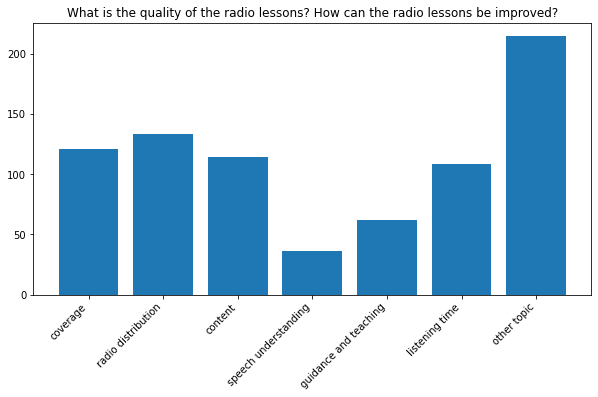

In [88]:
plt.figure(figsize=(10,5))
plt.bar(radio_lessons_good_group.columns, radio_lessons_good_group.sum())
plt.title('What is the quality of the radio lessons? How can the radio lessons be improved?')
plt.xticks(rotation=45, ha='right')
plt.show()

In [79]:
radio_lessons_good_group.loc[:,'coverage'].sum() / radio_lessons_good.shape[0]

0.19484702093397746

In [80]:
radio_lessons_good_group.loc[:,'radio distribution'].sum() / radio_lessons_good.shape[0]

0.214170692431562

In [81]:
radio_lessons_good_group.loc[:,'content'].sum() / radio_lessons_good.shape[0]

content    0.183575
content    0.183575
dtype: float64

In [82]:
radio_lessons_good_group.loc[:,'speech understanding'].sum() / radio_lessons_good.shape[0]

0.057971014492753624

In [84]:
radio_lessons_good_group.loc[:,'guidance and teaching'].sum() / radio_lessons_good.shape[0]

0.0998389694041868

In [85]:
radio_lessons_good_group.loc[:,'listening time'].sum() / radio_lessons_good.shape[0]

0.17391304347826086

#### Trigram Vectorization
Radio Lessons Fair Quality

In [89]:
radio_lessons_fair_tri = bow_vectorization(data = radio_lessons_fair.dropna(),
                                          index = radio_lessons_fair.dropna().index,
                                          n_grams=(3, 3))

750 words in dictionary.


In [90]:
# radio_lessons_fair_tri.sum().sort_values(ascending=False)[:30]

#### Group Trigrams
Trigrams about the coverage

In [91]:
coverage_1 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'provis', radio_lessons_fair_tri.columns)
print(len(coverage_1))

79


In [92]:
coverage_2 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'exten', radio_lessons_fair_tri.columns)
print(len(coverage_2))

75


In [93]:
coverage_3 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'avail', radio_lessons_fair_tri.columns)
print(len(coverage_3))

80


In [94]:
coverage_4 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'local', radio_lessons_fair_tri.columns)
print(len(coverage_4))

79


In [95]:
coverage = list(set(coverage_1 + coverage_2 + coverage_3 + coverage_4))
len(coverage)

74

Trigrams about the provision of radios

In [96]:
power = search(['powe','energ'],None, radio_lessons_fair_tri.columns)
len(power)

6

In [97]:
provision = search(['provis','dist','provid','everyone'], None, radio_lessons_fair_tri.columns)
len(provision)

102

In [98]:
tv = search(['video', 'tv', 'tele'], None, radio_lessons_fair_tri.columns)
len(tv)

8

Trigrams about content

In [99]:
content = search(['subject', 'time', 'guid'], None, radio_lessons_fair_tri.columns)
len(content)

83

Trigrams about speech

In [100]:
language = search(['language','trans','arab', 'pronunc'], None, radio_lessons_fair_tri.columns)
len(language)

29

In [101]:
speed = search(['speed','unders'], None, radio_lessons_fair_tri.columns)
len(speed)

23

Trigrams about teaching

In [102]:
teaching = search(['guide', 'support', 'teacher', 'follow', 'expla', 'slow', 'question'], None, radio_lessons_fair_tri.columns)
len(teaching)

102

Tigrams about school re-opening

In [103]:
school = search(['reopen', 'open'], None, radio_lessons_fair_tri.columns)
len(school)

37

Tigrams about time (to listen, of broadcast)

In [104]:
time = search(['time', 'repeat', 'timing', 'tmie', 'freq'], None, radio_lessons_fair_tri.columns)
len(time)

94

Don't Know (DK)

In [105]:
dk = search(["don't", 'idea', 'nothing'], None, radio_lessons_fair_tri.columns)
len(dk)

2

Count one per concept apperance (not word)

In [106]:
cover = radio_lessons_fair_tri[coverage]

In [107]:
r_provision = radio_lessons_fair_tri[list(set(power + provision + tv))]

In [108]:
l_content = radio_lessons_fair_tri[content]

In [109]:
teach = radio_lessons_fair_tri[teaching]

In [110]:
r_time = radio_lessons_fair_tri[time]

In [111]:
l_speech = radio_lessons_fair_tri[list(set(language +  speed))]

The rest of the Trigrams

In [112]:
other = radio_lessons_fair_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    teach.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    l_speech.columns.to_list(), axis=1)

In [113]:
test_other = radio_lessons_fair_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    teach.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    l_speech.columns.to_list(), axis=1)
len(test_other.columns.to_list())

359

In [114]:
cover = cover.sum(axis=1)
content = l_content.sum(axis=1)
speech = l_speech.sum(axis=1)
time = r_time.sum(axis=1)
provision = r_provision.sum(axis=1)
teach = teach.sum(axis=1)
other = other.sum(axis=1)

In [115]:
cover[cover != 0] = 1
content[content != 0] = 1
speech[speech != 0] = 1
time[time != 0] = 1
provision[provision != 0] = 1
teach[teach != 0] = 1
other[other != 0] = 1

In [116]:
coverage = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['coverage'])
coverage.loc[cover[cover == 1].index,:] = 1

prov = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['radio distribution'])
prov.loc[provision[provision == 1].index,:] = 1

cont = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['content'])
cont.loc[content[content == 1].index,:] = 1

form_speech = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['speech understanding'])
form_speech.loc[speech[speech == 1].index,:] = 1

teaching = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['guidance and teaching'])
teaching.loc[teach[teach == 1].index,:] = 1

timing = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['listening time'])
timing.loc[time[time == 1].index,:] = 1

other_w = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['other topic'])
other_w.loc[other[other == 1].index,:] = 1

In [117]:
radio_lessons_fair_group = pd.concat([coverage, prov, cont, cont, form_speech, teaching, timing, other_w], axis=1)

Visualization

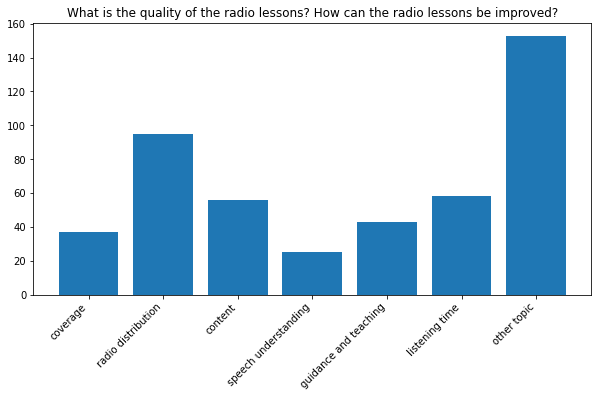

In [118]:
plt.figure(figsize=(10,5))
plt.bar(radio_lessons_fair_group.columns, radio_lessons_fair_group.sum())
plt.title('What is the quality of the radio lessons? How can the radio lessons be improved?')
plt.xticks(rotation=45, ha='right')
plt.show()

In [125]:
radio_lessons_fair_group.loc[:,'coverage'].sum() / radio_lessons_fair.shape[0]

0.09736842105263158

In [126]:
radio_lessons_fair_group.loc[:,'radio distribution'].sum() / radio_lessons_fair.shape[0]

0.25

In [127]:
radio_lessons_fair_group.loc[:,'content'].sum() / radio_lessons_fair.shape[0]

content    0.147368
content    0.147368
dtype: float64

In [128]:
radio_lessons_fair_group.loc[:,'speech understanding'].sum() / radio_lessons_fair.shape[0]

0.06578947368421052

In [129]:
radio_lessons_fair_group.loc[:,'guidance and teaching'].sum() / radio_lessons_fair.shape[0]

0.11315789473684211

In [130]:
radio_lessons_fair_group.loc[:,'listening time'].sum() / radio_lessons_good.shape[0]

0.09339774557165861

#### Trigram Vectorization
Radio Lessons Very Good Quality

In [131]:
radio_lessons_vgood_tri = bow_vectorization(data = radio_lessons_vgood.dropna(),
                                          index = radio_lessons_vgood.dropna().index,
                                          n_grams=(3, 3))

300 words in dictionary.


In [132]:
# radio_lessons_fair_tri.sum().sort_values(ascending=False)[:30]

#### Group Trigrams
Trigrams about the coverage

In [133]:
coverage_1 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'provis', radio_lessons_vgood_tri.columns)
print(len(coverage_1))

30


In [134]:
coverage_2 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'exten', radio_lessons_vgood_tri.columns)
print(len(coverage_2))

25


In [135]:
coverage_3 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'avail', radio_lessons_vgood_tri.columns)
print(len(coverage_3))

30


In [136]:
coverage_4 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'local', radio_lessons_vgood_tri.columns)
print(len(coverage_4))

31


In [137]:
coverage = list(set(coverage_1 + coverage_2 + coverage_3 + coverage_4))
len(coverage)

26

Trigrams about the provision of radios

In [138]:
power = search(['powe','energ'],None, radio_lessons_vgood_tri.columns)
len(power)

4

In [139]:
provision = search(['provis','dist','provid','everyone'], None, radio_lessons_vgood_tri.columns)
len(provision)

23

In [140]:
tv = search(['video', 'tv', 'tele'], None, radio_lessons_vgood_tri.columns)
len(tv)

0

Trigrams about content

In [141]:
content = search(['subject', 'time', 'guid'], None, radio_lessons_vgood_tri.columns)
len(content)

58

Trigrams about speech

In [142]:
language = search(['language','trans','arab', 'pronunc'], None, radio_lessons_vgood_tri.columns)
len(language)

9

In [143]:
speed = search(['speed','unders'], None, radio_lessons_vgood_tri.columns)
len(speed)

6

Trigrams about teaching

In [144]:
teaching = search(['guide', 'support', 'teacher', 'follow', 'expla', 'slow', 'question'], None, radio_lessons_vgood_tri.columns)
len(teaching)

49

Tigrams about school re-opening

In [145]:
school = search(['reopen', 'open'], None, radio_lessons_vgood_tri.columns)
len(school)

6

Tigrams about time (to listen, of broadcast)

In [146]:
time = search(['time', 'repeat', 'timing', 'tmie', 'freq'], None, radio_lessons_vgood_tri.columns)
len(time)

54

Count one per concept apperance (not word)

In [147]:
cover = radio_lessons_vgood_tri[coverage]

In [148]:
r_provision = radio_lessons_vgood_tri[list(set(power + provision + tv))]

In [149]:
l_content = radio_lessons_vgood_tri[content]

In [150]:
teach = radio_lessons_vgood_tri[teaching]

In [151]:
r_time = radio_lessons_vgood_tri[time]

In [152]:
l_speech = radio_lessons_vgood_tri[list(set(language +  speed))]

The rest of the Trigrams

In [153]:
other = radio_lessons_vgood_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    teach.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    l_speech.columns.to_list(), axis=1)

In [154]:
test_other = radio_lessons_vgood_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    teach.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    l_speech.columns.to_list(), axis=1)
len(test_other.columns.to_list())

150

In [155]:
cover = cover.sum(axis=1)
content = l_content.sum(axis=1)
speech = l_speech.sum(axis=1)
time = r_time.sum(axis=1)
provision = r_provision.sum(axis=1)
teach = teach.sum(axis=1)
other = other.sum(axis=1)

In [156]:
cover[cover != 0] = 1
content[content != 0] = 1
speech[speech != 0] = 1
time[time != 0] = 1
provision[provision != 0] = 1
teach[teach != 0] = 1
other[other != 0] = 1

In [157]:
coverage = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['coverage'])
coverage.loc[cover[cover == 1].index,:] = 1

prov = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['radio distribution'])
prov.loc[provision[provision == 1].index,:] = 1

cont = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['content'])
cont.loc[content[content == 1].index,:] = 1

form_speech = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['speech understanding'])
form_speech.loc[speech[speech == 1].index,:] = 1

teaching = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['guidance and teaching'])
teaching.loc[teach[teach == 1].index,:] = 1

timing = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['listening time'])
timing.loc[time[time == 1].index,:] = 1

other_w = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['other biagrams'])
other_w.loc[other[other == 1].index,:] = 1

In [158]:
radio_lessons_vgood_group = pd.concat([coverage, prov, cont, cont, form_speech, teaching, timing, other_w], axis=1)

Visualization

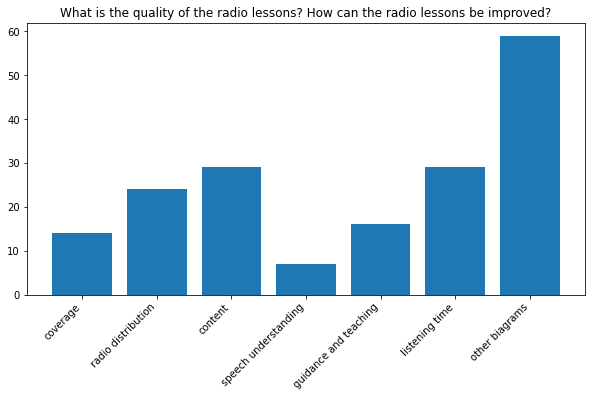

In [159]:
plt.figure(figsize=(10,5))
plt.bar(radio_lessons_vgood_group.columns, radio_lessons_vgood_group.sum())
plt.title('What is the quality of the radio lessons? How can the radio lessons be improved?')
plt.xticks(rotation=45, ha='right')
plt.show()

In [160]:
radio_lessons_vgood_group.loc[:,'coverage'].sum() / radio_lessons_vgood.shape[0]

0.09655172413793103

In [161]:
radio_lessons_vgood_group.loc[:,'radio distribution'].sum() / radio_lessons_vgood.shape[0]

0.16551724137931034

In [162]:
radio_lessons_vgood_group.loc[:,'content'].sum() / radio_lessons_vgood.shape[0]

content    0.2
content    0.2
dtype: float64

In [163]:
radio_lessons_vgood_group.loc[:,'speech understanding'].sum() / radio_lessons_vgood.shape[0]

0.04827586206896552

In [164]:
radio_lessons_vgood_group.loc[:,'guidance and teaching'].sum() / radio_lessons_vgood.shape[0]

0.1103448275862069

In [165]:
radio_lessons_vgood_group.loc[:,'listening time'].sum() / radio_lessons_vgood.shape[0]

0.2

#### Trigram Vectorization
Radio Lessons No Good Quality

In [166]:
radio_lessons_ngood_tri = bow_vectorization(data = radio_lessons_ngood.dropna(),
                                          index = radio_lessons_ngood.dropna().index,
                                          n_grams=(3, 3))

389 words in dictionary.


In [167]:
# radio_lessons_fair_tri.sum().sort_values(ascending=False)[:30]

#### Group Trigrams
Trigrams about the coverage

In [168]:
coverage_1 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'provis', radio_lessons_ngood_tri.columns)
print(len(coverage_1))

50


In [169]:
coverage_2 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'exten', radio_lessons_ngood_tri.columns)
print(len(coverage_2))

49


In [170]:
coverage_3 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'avail', radio_lessons_ngood_tri.columns)
print(len(coverage_3))

50


In [171]:
coverage_4 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'local', radio_lessons_ngood_tri.columns)
print(len(coverage_4))

49


In [172]:
coverage = list(set(coverage_1 + coverage_2 + coverage_3 + coverage_4))
len(coverage)

46

Trigrams about the provision of radios

In [173]:
power = search(['powe','energ'],None, radio_lessons_ngood_tri.columns)
len(power)

6

In [174]:
provision = search(['provis','dist','provid','everyone'], None, radio_lessons_ngood_tri.columns)
len(provision)

46

In [175]:
tv = search(['video', 'tv', 'tele'], None, radio_lessons_ngood_tri.columns)
len(tv)

12

Trigrams about content

In [176]:
content = search(['subject', 'time', 'guid'], None, radio_lessons_ngood_tri.columns)
len(content)

60

Trigrams about speech

In [177]:
language = search(['language','trans','arab', 'pronunc'], None, radio_lessons_ngood_tri.columns)
len(language)

12

In [178]:
speed = search(['speed','unders'], None, radio_lessons_ngood_tri.columns)
len(speed)

6

Trigrams about teaching

In [179]:
teaching = search(['guide', 'support', 'teacher', 'follow', 'expla', 'slow', 'question'], None, radio_lessons_ngood_tri.columns)
len(teaching)

57

Tigrams about school re-opening

In [180]:
school = search(['reopen', 'open'], None, radio_lessons_ngood_tri.columns)
len(school)

47

Tigrams about time (to listen, of broadcast)

In [181]:
time = search(['time', 'repeat', 'timing', 'tmie', 'freq'], None, radio_lessons_ngood_tri.columns)
len(time)

65

Count one per concept apperance (not word)

In [182]:
cover = radio_lessons_ngood_tri[coverage]

In [183]:
r_provision = radio_lessons_ngood_tri[list(set(power + provision + tv))]

In [184]:
l_content = radio_lessons_ngood_tri[content]

In [185]:
teach = radio_lessons_ngood_tri[teaching]

In [186]:
r_time = radio_lessons_ngood_tri[time]

In [187]:
l_speech = radio_lessons_ngood_tri[list(set(language +  speed))]

The rest of the Trigrams

In [188]:
other = radio_lessons_ngood_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    teach.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    l_speech.columns.to_list(), axis=1)

In [189]:
test_other = radio_lessons_ngood_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    teach.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    l_speech.columns.to_list(), axis=1)
len(test_other.columns.to_list())

181

In [190]:
cover = cover.sum(axis=1)
content = l_content.sum(axis=1)
speech = l_speech.sum(axis=1)
time = r_time.sum(axis=1)
provision = r_provision.sum(axis=1)
teach = teach.sum(axis=1)
other = other.sum(axis=1)

In [191]:
cover[cover != 0] = 1
content[content != 0] = 1
speech[speech != 0] = 1
time[time != 0] = 1
provision[provision != 0] = 1
teach[teach != 0] = 1
other[other != 0] = 1

In [192]:
coverage = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['coverage'])
coverage.loc[cover[cover == 1].index,:] = 1

prov = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['radio distribution'])
prov.loc[provision[provision == 1].index,:] = 1

cont = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['content'])
cont.loc[content[content == 1].index,:] = 1

form_speech = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['speech understanding'])
form_speech.loc[speech[speech == 1].index,:] = 1

teaching = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['guidance and teaching'])
teaching.loc[teach[teach == 1].index,:] = 1

timing = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['listening time'])
timing.loc[time[time == 1].index,:] = 1

other_w = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['other biagrams'])
other_w.loc[other[other == 1].index,:] = 1

In [193]:
radio_lessons_ngood_group = pd.concat([coverage, prov, cont, cont, form_speech, teaching, timing, other_w], axis=1)

Visualization

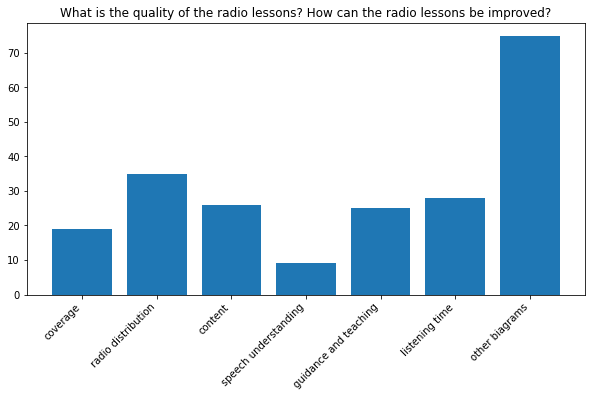

In [194]:
plt.figure(figsize=(10,5))
plt.bar(radio_lessons_ngood_group.columns, radio_lessons_ngood_group.sum())
plt.title('What is the quality of the radio lessons? How can the radio lessons be improved?')
plt.xticks(rotation=45, ha='right')
plt.show()

In [195]:
radio_lessons_ngood_group.loc[:,'coverage'].sum() / radio_lessons_ngood.shape[0]

0.11046511627906977

In [196]:
radio_lessons_ngood_group.loc[:,'radio distribution'].sum() / radio_lessons_ngood.shape[0]

0.20348837209302326

In [197]:
radio_lessons_ngood_group.loc[:,'content'].sum() / radio_lessons_ngood.shape[0]

content    0.151163
content    0.151163
dtype: float64

In [198]:
radio_lessons_ngood_group.loc[:,'speech understanding'].sum() / radio_lessons_ngood.shape[0]

0.05232558139534884

In [199]:
radio_lessons_ngood_group.loc[:,'guidance and teaching'].sum() / radio_lessons_ngood.shape[0]

0.14534883720930233

In [201]:
radio_lessons_ngood_group.loc[:,'listening time'].sum() / radio_lessons_ngood.shape[0]

0.16279069767441862

#### Save vectors and concepts

In [151]:
radio_lessons_good_group.to_csv('data/concepts/radio_lessons_good_concepts.csv')
radio_lessons_fair_group.to_csv('data/concepts/radio_lessons_fair_concepts.csv')

radio_lessons_vgood_group.to_csv('data/concepts/radio_lessons_vgood_concepts.csv')
radio_lessons_ngood_group.to_csv('data/concepts/radio_lessons_ngood_concepts.csv')

In [152]:
radio_lessons_good_tri.to_csv('data/tokens/radio_lessons_good.csv')
radio_lessons_fair_tri.to_csv('data/tokens/radio_lessons_fair.csv')

radio_lessons_vgood_tri.to_csv('data/tokens/radio_lessons_vgood.csv')
radio_lessons_ngood_tri.to_csv('data/tokens/radio_lessons_ngood.csv')